In [1]:
# Parameters (overridden during execution)
EPOCHS = 25
RUN_ID = 1
OUT_DIR = "/kaggle/working/outputs"

In [2]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [3]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from torchinfo import summary
from torchview import draw_graph

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter

In [6]:
!unzip -q "/content/archive (10).zip" -d /content/lung_cancer

In [7]:
import os
from pathlib import Path
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [8]:
BASE_ROOT  = Path("/content/lung_cancer/Data")
TRAIN_ROOT = BASE_ROOT / "train"
VAL_ROOT   = BASE_ROOT / "valid"
TEST_ROOT  = BASE_ROOT / "test"

assert TRAIN_ROOT.exists(), "Train folder not found"
assert VAL_ROOT.exists(),   "Valid folder not found"
assert TEST_ROOT.exists(),  "Test folder not found"


In [9]:
from torch.utils.data import Dataset, DataLoader

# -------------------------
# PyTorch Dataset
# -------------------------
class LungDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.class_names = sorted([
            d for d in os.listdir(root)
            if (root / d).is_dir()
        ])
        self.class_to_idx = {c: i for i, c in enumerate(self.class_names)}
        self.transform = transform

        for cls in self.class_names:
            cls_dir = root / cls
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append(
                        (cls_dir / img_name, self.class_to_idx[cls])
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, label


In [10]:
IMG_SIZE   = 224     # MUST match model input
BATCH_SIZE = 6

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # shape only
    transforms.ToTensor(),                    # required by PyTorch
])


In [11]:
train_ds = LungDataset(TRAIN_ROOT, transform)
val_ds   = LungDataset(VAL_ROOT,   transform)
test_ds  = LungDataset(TEST_ROOT,  transform)


In [12]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

print("Detected classes:")
for i, name in enumerate(CLASS_NAMES):
    print(f"{i}: {name}")

print(f"\nNumber of classes: {NUM_CLASSES}")


Detected classes:
0: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
2: normal
3: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa

Number of classes: 4


In [13]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True   # 🔥 ADD THIS
)


val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [14]:
def show_random_images_per_class(
    dataset,
    class_names,
    n_per_class=5,
    seed=42
):
    random.seed(seed)
    torch.manual_seed(seed)

    # Extract labels
    labels = np.array([label for _, label in dataset])
    num_classes = len(class_names)

    fig, axes = plt.subplots(
        num_classes,
        n_per_class,
        figsize=(3 * n_per_class, 3 * num_classes),
        squeeze=False
    )

    for cls_idx in range(num_classes):
        cls_indices = np.where(labels == cls_idx)[0]
        selected = np.random.choice(
            cls_indices,
            size=min(n_per_class, len(cls_indices)),
            replace=False
        )

        for col, idx in enumerate(selected):
            img, _ = dataset[idx]
            img = img.permute(1, 2, 0).numpy()

            ax = axes[cls_idx, col]
            ax.imshow(img)
            ax.axis("off")

            if col == 0:
                ax.set_ylabel(
                    class_names[cls_idx],
                    fontsize=12,
                    rotation=90,
                    labelpad=10
                )

    plt.tight_layout()
    plt.show()


In [15]:
class TwoMaxMinusMinPool2d(nn.Module):
    """
    Pooling layer that computes:
        output = (2 * max_pool) - min_pool

    Uses only optimized max-pooling kernels.
    Computational cost ~ 2× max pooling.
    Output shape matches standard pooling.
    """

    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()

        # Match PyTorch pooling semantics
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        # Fast max pooling (optimized C++/CUDA)
        max_pool = F.max_pool2d(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Fast min pooling via negation trick
        min_pool = -F.max_pool2d(
            -x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Final contrast-enhanced response
        return (2.0 * max_pool) - min_pool

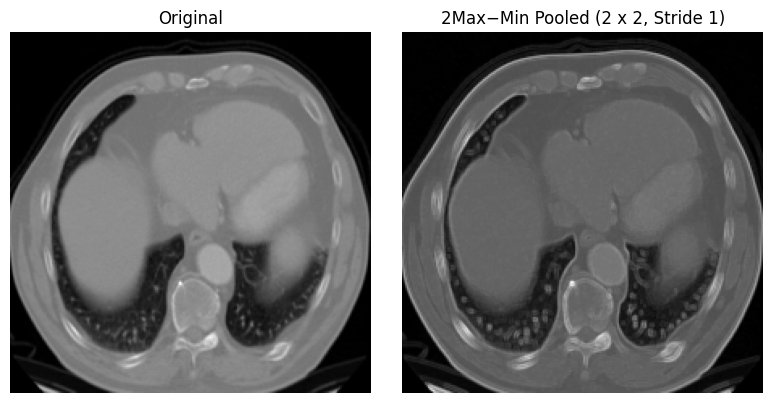

In [16]:
KERNEL_SIZE = 2
STRIDE = 1

# Get one batch
images, labels = next(iter(train_loader))

# Take first image only
img = images[0:1]  # shape: (1, C, H, W)

pool = TwoMaxMinusMinPool2d(kernel_size=KERNEL_SIZE, stride=STRIDE)
pool.eval()

with torch.no_grad():
    pooled = pool(img)

# Convert to numpy for display
img_np = img[0].cpu().numpy()
pooled_np = pooled[0].cpu().numpy()

# Pick one channel to visualize
ch = 0

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(img_np[ch], cmap="gray")
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(pooled_np[ch], cmap="gray")
axs[1].set_title(F"2Max−Min Pooled ({KERNEL_SIZE} x {KERNEL_SIZE}, Stride {STRIDE})")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from timm.models.vision_transformer import VisionTransformer


class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # ------------------------------
        # 1️⃣ Load pretrained MobileNetV2
        # ------------------------------
        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks1 = len(pretrained_model.features)

        # Freeze first half
        for param in pretrained_model.features[:num_blocks1 // 2].parameters():
            param.requires_grad = False

        # Split MobileNetV2
        self.mobilenet_feature_blocks_1 = nn.Sequential(
            *pretrained_model.features[:num_blocks1 - 3]
        )
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks1 - 3]
        self.mobilenet_block_mid = pretrained_model.features[num_blocks1 - 2]
        self.mobilenet_block_last = pretrained_model.features[num_blocks1 - 1]

        # Channel sizes
        ch_2nd_last = self.mobilenet_block_2nd_last.out_channels   # 160
        ch_mid = self.mobilenet_block_mid.out_channels             # 320
        ch_last = self.mobilenet_block_last.out_channels           # 1280
        ch_concat = ch_last + ch_2nd_last                          # 1440

        # ------------------------------
        # 2️⃣ CNN → ViT Adapter
        # ------------------------------
        self.cnn_to_vit_adapter = nn.Sequential(
            nn.Conv2d(ch_mid, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        )

        self.vit_encoder1 = VisionTransformer(
            img_size=56,
            patch_size=8,
            in_chans=16,
            num_classes=0,
            embed_dim=48,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()


        old_proj = self.vit_encoder1.patch_embed.proj
        self.vit_encoder1.patch_embed.proj = nn.Conv2d(
            old_proj.in_channels,
            old_proj.out_channels,
            kernel_size=8,
            stride=4,
            bias=old_proj.bias is not None,
        )

        # Update patch count
        img_h, img_w = self.vit_encoder1.patch_embed.img_size
        dummy = torch.zeros(1, old_proj.in_channels, img_h, img_w)

        with torch.no_grad():
            _, _, h, w = self.vit_encoder1.patch_embed.proj(dummy).shape

        num_patches = h * w
        self.vit_encoder1.patch_embed.num_patches = num_patches
        self.vit_encoder1.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, self.vit_encoder1.embed_dim)
        )
        nn.init.trunc_normal_(self.vit_encoder1.pos_embed, std=0.02)


        self.twomax_minus_min_pool = TwoMaxMinusMinPool2d(
            kernel_size=2,
            stride=1
        )

        self.post_pool_gelu = nn.GELU()

        self.vit_encoder2 = VisionTransformer(
            img_size=28,
            patch_size=7,
            in_chans=32,
            num_classes=0,
            embed_dim=48,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()

        self.cnn_parallel_head = nn.Sequential(
            nn.Conv2d(ch_concat, 128, kernel_size=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
        )

        self.fusion_dim = 48 + 48 + 128
        self.efm_bn = nn.BatchNorm1d(self.fusion_dim)

        # Final classifier
        self.classifier_head = nn.Linear(self.fusion_dim, num_classes)

    def forward(self, x):


        features_1 = self.mobilenet_feature_blocks_1(x)
        features_2nd_last = self.mobilenet_block_2nd_last(features_1)
        features_mid = self.mobilenet_block_mid(features_2nd_last)
        features_last = self.mobilenet_block_last(features_mid)

        concatenated_cnn_features = torch.cat(
            [features_last, features_2nd_last], dim=1
        )


        x = features_mid
        intermediate = None

        for i, layer in enumerate(self.cnn_to_vit_adapter):
            x = layer(x)

            if i == len(self.cnn_to_vit_adapter) - 5:
                intermediate = x

        vit_input1 = x
        vit_input2 = intermediate

        vit_features1 = self.vit_encoder1(vit_input1)

        vit_input2 = self.twomax_minus_min_pool(vit_input2)
        vit_input2 = self.post_pool_gelu(vit_input2)

        vit_input2 = F.interpolate(
            vit_input2,
            size=(28, 28),
            mode="bilinear",
            align_corners=False
        )

        vit_features2 = self.vit_encoder2(vit_input2)


        cnn_features = self.cnn_parallel_head(concatenated_cnn_features)

        combined = torch.cat(
            [vit_features1, vit_features2, cnn_features],
            dim=1
        )

        combined = self.efm_bn(combined)

        # Final classification
        return self.classifier_head(combined)


In [18]:
model = CNN_ViT_Model(num_classes=NUM_CLASSES)
model.to(device)
summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 146MB/s]


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 4]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

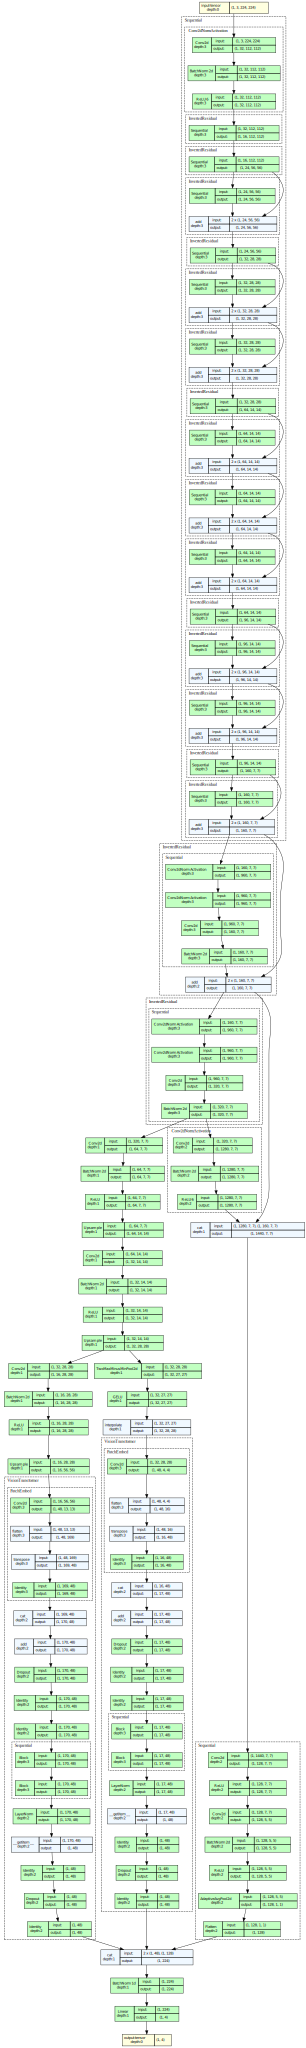

In [ ]:
model.to(device)


dummy_input = torch.randn(1, 3, 224, 224, device=device)


model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False 
)


svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [20]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()

        # Skip AUC if only one class is present
        if np.unique(class_y_true).size < 2:
            continue
        try:
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        except ValueError:
            continue

    auc_avg = np.mean(auc_scores) if auc_scores else 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [21]:
# Hyperparameters
num_epochs       = EPOCHS
initial_lr       = 2e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [22]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric: [] for metric in metric_names}
val_metrics_history = {metric: [] for metric in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0.0
    all_train_predictions = []
    all_train_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_predictions.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_train_loss = total_train_loss / len(train_loader)
    all_train_predictions = np.array(all_train_predictions)
    all_train_targets = np.array(all_train_targets)

    train_metrics = custom_metrics(torch.tensor(all_train_predictions), torch.tensor(all_train_targets), average_train_loss)
    training_metrics_line = "Train Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(training_metrics_line)

    for metric in metric_names:
        train_metrics_history[metric].append(train_metrics[metric])

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    all_val_predictions = []
    all_val_targets = []
    start_val_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            all_val_predictions.extend(outputs.detach().cpu().numpy())
            all_val_targets.extend(targets.detach().cpu().numpy())

    end_val_time = time.time()
    epoch_validation_time = end_val_time - start_val_time
    total_validation_time += epoch_validation_time

    average_val_loss = total_val_loss / len(val_loader)
    all_val_predictions = np.array(all_val_predictions)
    all_val_targets = np.array(all_val_targets)

    val_metrics = custom_metrics(torch.tensor(all_val_predictions), torch.tensor(all_val_targets), average_val_loss)
    validation_metrics_line = "Val Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(validation_metrics_line)

    for metric in metric_names:
        val_metrics_history[metric].append(val_metrics[metric])

    # Update LR via scheduler rather than manual mutliplication
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f} — LR: {current_lr:.6f}")

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / (epoch + 1)
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Epoch [1/25]: 100%|██████████| 102/102 [00:06<00:00, 15.79it/s]


Train Metrics - loss: 0.8852, accuracy: 0.6258, precision: 0.6166, recall: 0.6258, f1_score: 0.6185, specificity: 0.5692, sensitivity: 0.8321, mcc: 0.4967, auc: 0.8287


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.57it/s]


Val Metrics - loss: 0.5022, accuracy: 0.7778, precision: 0.7805, recall: 0.7778, f1_score: 0.7782, specificity: 0.8261, sensitivity: 0.8776, mcc: 0.6976, auc: 0.9384
Epoch 0/25 — Loss: 0.9088 — LR: 0.000200


Training Epoch [2/25]: 100%|██████████| 102/102 [00:04<00:00, 20.71it/s]


Train Metrics - loss: 0.4156, accuracy: 0.8513, precision: 0.8503, recall: 0.8513, f1_score: 0.8503, specificity: 0.8256, sensitivity: 0.9281, mcc: 0.7997, auc: 0.9529


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.86it/s]


Val Metrics - loss: 0.4907, accuracy: 0.7778, precision: 0.7935, recall: 0.7778, f1_score: 0.7791, specificity: 0.6522, sensitivity: 0.9184, mcc: 0.7044, auc: 0.9425
Epoch 1/25 — Loss: 0.8892 — LR: 0.000200


Training Epoch [3/25]: 100%|██████████| 102/102 [00:05<00:00, 17.52it/s]


Train Metrics - loss: 0.2592, accuracy: 0.9069, precision: 0.9069, recall: 0.9069, f1_score: 0.9067, specificity: 0.8821, sensitivity: 0.9592, mcc: 0.8747, auc: 0.9831


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.13it/s]


Val Metrics - loss: 0.5068, accuracy: 0.8472, precision: 0.8694, recall: 0.8472, f1_score: 0.8513, specificity: 0.8261, sensitivity: 0.9592, mcc: 0.7990, auc: 0.9461
Epoch 2/25 — Loss: 0.2446 — LR: 0.000200


Training Epoch [4/25]: 100%|██████████| 102/102 [00:04<00:00, 21.28it/s]


Train Metrics - loss: 0.1614, accuracy: 0.9542, precision: 0.9545, recall: 0.9542, f1_score: 0.9542, specificity: 0.9536, sensitivity: 0.9737, mcc: 0.9383, auc: 0.9904


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.53it/s]


Val Metrics - loss: 0.3536, accuracy: 0.8611, precision: 0.8737, recall: 0.8611, f1_score: 0.8620, specificity: 0.9565, sensitivity: 0.8776, mcc: 0.8144, auc: 0.9724
Epoch 3/25 — Loss: 0.8162 — LR: 0.000200


Training Epoch [5/25]: 100%|██████████| 102/102 [00:05<00:00, 17.48it/s]


Train Metrics - loss: 0.1801, accuracy: 0.9379, precision: 0.9381, recall: 0.9379, f1_score: 0.9378, specificity: 0.9227, sensitivity: 0.9713, mcc: 0.9165, auc: 0.9900


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.64it/s]


Val Metrics - loss: 0.5011, accuracy: 0.8750, precision: 0.9123, recall: 0.8750, f1_score: 0.8814, specificity: 0.8696, sensitivity: 0.9796, mcc: 0.8416, auc: 0.9522
Epoch 4/25 — Loss: 0.1330 — LR: 0.000200


Training Epoch [6/25]: 100%|██████████| 102/102 [00:04<00:00, 21.17it/s]


Train Metrics - loss: 0.2808, accuracy: 0.9036, precision: 0.9039, recall: 0.9036, f1_score: 0.9033, specificity: 0.8821, sensitivity: 0.9664, mcc: 0.8704, auc: 0.9759


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.38it/s]


Val Metrics - loss: 0.3590, accuracy: 0.8611, precision: 0.8751, recall: 0.8611, f1_score: 0.8617, specificity: 0.9130, sensitivity: 0.8980, mcc: 0.8154, auc: 0.9636
Epoch 5/25 — Loss: 0.4451 — LR: 0.000200


Training Epoch [7/25]: 100%|██████████| 102/102 [00:05<00:00, 18.73it/s]


Train Metrics - loss: 0.1524, accuracy: 0.9493, precision: 0.9498, recall: 0.9493, f1_score: 0.9494, specificity: 0.9278, sensitivity: 0.9833, mcc: 0.9319, auc: 0.9910


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 14.46it/s]


Val Metrics - loss: 0.3854, accuracy: 0.8611, precision: 0.8663, recall: 0.8611, f1_score: 0.8626, specificity: 0.8261, sensitivity: 0.9184, mcc: 0.8124, auc: 0.9667
Epoch 6/25 — Loss: 0.2303 — LR: 0.000200


Training Epoch [8/25]: 100%|██████████| 102/102 [00:04<00:00, 20.66it/s]


Train Metrics - loss: 0.1456, accuracy: 0.9493, precision: 0.9497, recall: 0.9493, f1_score: 0.9494, specificity: 0.9639, sensitivity: 0.9713, mcc: 0.9317, auc: 0.9903


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.27it/s]


Val Metrics - loss: 0.2615, accuracy: 0.9028, precision: 0.9050, recall: 0.9028, f1_score: 0.9026, specificity: 0.8261, sensitivity: 0.9592, mcc: 0.8695, auc: 0.9818
Epoch 7/25 — Loss: 0.4480 — LR: 0.000200


Training Epoch [9/25]: 100%|██████████| 102/102 [00:04<00:00, 21.41it/s]


Train Metrics - loss: 0.1585, accuracy: 0.9493, precision: 0.9506, recall: 0.9493, f1_score: 0.9494, specificity: 0.9639, sensitivity: 0.9593, mcc: 0.9319, auc: 0.9894


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 15.90it/s]


Val Metrics - loss: 0.2920, accuracy: 0.8750, precision: 0.9033, recall: 0.8750, f1_score: 0.8791, specificity: 0.8261, sensitivity: 0.9592, mcc: 0.8397, auc: 0.9753
Epoch 8/25 — Loss: 0.0846 — LR: 0.000200


Training Epoch [10/25]: 100%|██████████| 102/102 [00:05<00:00, 18.05it/s]


Train Metrics - loss: 0.1144, accuracy: 0.9592, precision: 0.9593, recall: 0.9592, f1_score: 0.9592, specificity: 0.9485, sensitivity: 0.9785, mcc: 0.9450, auc: 0.9940


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.30it/s]


Val Metrics - loss: 0.3188, accuracy: 0.9028, precision: 0.9141, recall: 0.9028, f1_score: 0.9034, specificity: 0.9565, sensitivity: 0.9184, mcc: 0.8714, auc: 0.9679
Epoch 9/25 — Loss: 0.3701 — LR: 0.000200


Training Epoch [11/25]: 100%|██████████| 102/102 [00:04<00:00, 21.35it/s]


Train Metrics - loss: 0.0923, accuracy: 0.9690, precision: 0.9693, recall: 0.9690, f1_score: 0.9691, specificity: 0.9641, sensitivity: 0.9904, mcc: 0.9582, auc: 0.9955


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.89it/s]


Val Metrics - loss: 0.3350, accuracy: 0.8750, precision: 0.8941, recall: 0.8750, f1_score: 0.8767, specificity: 0.9130, sensitivity: 0.9184, mcc: 0.8359, auc: 0.9773
Epoch 10/25 — Loss: 0.0640 — LR: 0.000194


Training Epoch [12/25]: 100%|██████████| 102/102 [00:05<00:00, 17.13it/s]


Train Metrics - loss: 0.0905, accuracy: 0.9722, precision: 0.9723, recall: 0.9722, f1_score: 0.9722, specificity: 0.9795, sensitivity: 0.9856, mcc: 0.9626, auc: 0.9953


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.34it/s]


Val Metrics - loss: 0.2781, accuracy: 0.9028, precision: 0.9141, recall: 0.9028, f1_score: 0.9019, specificity: 0.9565, sensitivity: 0.9184, mcc: 0.8726, auc: 0.9774
Epoch 11/25 — Loss: 0.1294 — LR: 0.000188


Training Epoch [13/25]: 100%|██████████| 102/102 [00:04<00:00, 21.12it/s]


Train Metrics - loss: 0.0789, accuracy: 0.9788, precision: 0.9788, recall: 0.9788, f1_score: 0.9786, specificity: 0.9897, sensitivity: 0.9856, mcc: 0.9714, auc: 0.9961


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.20it/s]


Val Metrics - loss: 0.3645, accuracy: 0.8889, precision: 0.9177, recall: 0.8889, f1_score: 0.8938, specificity: 0.8261, sensitivity: 0.9796, mcc: 0.8583, auc: 0.9759
Epoch 12/25 — Loss: 0.0244 — LR: 0.000183


Training Epoch [14/25]: 100%|██████████| 102/102 [00:05<00:00, 17.39it/s]


Train Metrics - loss: 0.0907, accuracy: 0.9739, precision: 0.9741, recall: 0.9739, f1_score: 0.9738, specificity: 0.9897, sensitivity: 0.9785, mcc: 0.9648, auc: 0.9938


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.17it/s]


Val Metrics - loss: 0.3050, accuracy: 0.8889, precision: 0.9106, recall: 0.8889, f1_score: 0.8913, specificity: 0.9130, sensitivity: 0.9796, mcc: 0.8553, auc: 0.9804
Epoch 13/25 — Loss: 0.0964 — LR: 0.000177


Training Epoch [15/25]: 100%|██████████| 102/102 [00:04<00:00, 21.31it/s]


Train Metrics - loss: 0.0939, accuracy: 0.9788, precision: 0.9790, recall: 0.9788, f1_score: 0.9788, specificity: 0.9897, sensitivity: 0.9833, mcc: 0.9714, auc: 0.9943


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.60it/s]


Val Metrics - loss: 0.3660, accuracy: 0.9167, precision: 0.9340, recall: 0.9167, f1_score: 0.9189, specificity: 0.9565, sensitivity: 0.9796, mcc: 0.8917, auc: 0.9702
Epoch 14/25 — Loss: 0.1787 — LR: 0.000172


Training Epoch [16/25]: 100%|██████████| 102/102 [00:05<00:00, 17.42it/s]


Train Metrics - loss: 0.0804, accuracy: 0.9771, precision: 0.9772, recall: 0.9771, f1_score: 0.9771, specificity: 0.9692, sensitivity: 0.9856, mcc: 0.9692, auc: 0.9963


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.40it/s]


Val Metrics - loss: 0.3297, accuracy: 0.9028, precision: 0.9107, recall: 0.9028, f1_score: 0.9020, specificity: 0.9565, sensitivity: 0.9388, mcc: 0.8710, auc: 0.9765
Epoch 15/25 — Loss: 0.0599 — LR: 0.000167


Training Epoch [17/25]: 100%|██████████| 102/102 [00:04<00:00, 21.28it/s]


Train Metrics - loss: 0.0505, accuracy: 0.9869, precision: 0.9869, recall: 0.9869, f1_score: 0.9869, specificity: 0.9897, sensitivity: 0.9952, mcc: 0.9824, auc: 0.9976


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.76it/s]


Val Metrics - loss: 0.3930, accuracy: 0.8889, precision: 0.9275, recall: 0.8889, f1_score: 0.8947, specificity: 0.7826, sensitivity: 1.0000, mcc: 0.8624, auc: 0.9813
Epoch 16/25 — Loss: 0.0383 — LR: 0.000162


Training Epoch [18/25]: 100%|██████████| 102/102 [00:05<00:00, 17.03it/s]


Train Metrics - loss: 0.0491, accuracy: 0.9902, precision: 0.9902, recall: 0.9902, f1_score: 0.9902, specificity: 0.9897, sensitivity: 0.9952, mcc: 0.9868, auc: 0.9970


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.32it/s]


Val Metrics - loss: 0.3106, accuracy: 0.9028, precision: 0.9201, recall: 0.9028, f1_score: 0.9050, specificity: 0.9130, sensitivity: 0.9592, mcc: 0.8729, auc: 0.9804
Epoch 17/25 — Loss: 0.0515 — LR: 0.000157


Training Epoch [19/25]: 100%|██████████| 102/102 [00:04<00:00, 21.22it/s]


Train Metrics - loss: 0.0479, accuracy: 0.9886, precision: 0.9886, recall: 0.9886, f1_score: 0.9886, specificity: 0.9897, sensitivity: 0.9928, mcc: 0.9846, auc: 0.9975


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.82it/s]


Val Metrics - loss: 0.3075, accuracy: 0.9306, precision: 0.9387, recall: 0.9306, f1_score: 0.9310, specificity: 0.9565, sensitivity: 0.9592, mcc: 0.9083, auc: 0.9766
Epoch 18/25 — Loss: 0.1452 — LR: 0.000152


Training Epoch [20/25]: 100%|██████████| 102/102 [00:05<00:00, 18.23it/s]


Train Metrics - loss: 0.0398, accuracy: 0.9918, precision: 0.9919, recall: 0.9918, f1_score: 0.9918, specificity: 0.9897, sensitivity: 0.9952, mcc: 0.9890, auc: 0.9986


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 17.47it/s]


Val Metrics - loss: 0.4120, accuracy: 0.8750, precision: 0.9015, recall: 0.8750, f1_score: 0.8807, specificity: 0.8696, sensitivity: 0.9592, mcc: 0.8368, auc: 0.9704
Epoch 19/25 — Loss: 0.2840 — LR: 0.000147


Training Epoch [21/25]: 100%|██████████| 102/102 [00:04<00:00, 21.39it/s]


Train Metrics - loss: 0.0373, accuracy: 0.9886, precision: 0.9886, recall: 0.9886, f1_score: 0.9886, specificity: 0.9949, sensitivity: 0.9976, mcc: 0.9846, auc: 0.9984


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 24.01it/s]


Val Metrics - loss: 0.3615, accuracy: 0.9028, precision: 0.9201, recall: 0.9028, f1_score: 0.9045, specificity: 0.9130, sensitivity: 0.9592, mcc: 0.8736, auc: 0.9755
Epoch 20/25 — Loss: 0.0103 — LR: 0.000143


Training Epoch [22/25]: 100%|██████████| 102/102 [00:04<00:00, 20.57it/s]


Train Metrics - loss: 0.0751, accuracy: 0.9869, precision: 0.9871, recall: 0.9869, f1_score: 0.9869, specificity: 0.9897, sensitivity: 0.9880, mcc: 0.9824, auc: 0.9948


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 12.48it/s]


Val Metrics - loss: 0.3252, accuracy: 0.8611, precision: 0.8848, recall: 0.8611, f1_score: 0.8659, specificity: 0.8261, sensitivity: 0.9592, mcc: 0.8178, auc: 0.9795
Epoch 21/25 — Loss: 0.0077 — LR: 0.000139


Training Epoch [23/25]: 100%|██████████| 102/102 [00:05<00:00, 19.37it/s]


Train Metrics - loss: 0.0675, accuracy: 0.9853, precision: 0.9854, recall: 0.9853, f1_score: 0.9853, specificity: 0.9949, sensitivity: 0.9904, mcc: 0.9802, auc: 0.9951


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.37it/s]


Val Metrics - loss: 0.2605, accuracy: 0.9028, precision: 0.9174, recall: 0.9028, f1_score: 0.9048, specificity: 0.8696, sensitivity: 0.9796, mcc: 0.8728, auc: 0.9841
Epoch 22/25 — Loss: 0.0204 — LR: 0.000135


Training Epoch [24/25]: 100%|██████████| 102/102 [00:04<00:00, 21.32it/s]


Train Metrics - loss: 0.0707, accuracy: 0.9788, precision: 0.9787, recall: 0.9788, f1_score: 0.9787, specificity: 0.9949, sensitivity: 0.9904, mcc: 0.9714, auc: 0.9952


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 20.05it/s]


Val Metrics - loss: 0.3482, accuracy: 0.8889, precision: 0.9028, recall: 0.8889, f1_score: 0.8906, specificity: 0.9130, sensitivity: 0.9592, mcc: 0.8521, auc: 0.9757
Epoch 23/25 — Loss: 0.0218 — LR: 0.000131


Training Epoch [25/25]: 100%|██████████| 102/102 [00:05<00:00, 17.87it/s]


Train Metrics - loss: 0.0485, accuracy: 0.9869, precision: 0.9869, recall: 0.9869, f1_score: 0.9869, specificity: 0.9897, sensitivity: 0.9928, mcc: 0.9824, auc: 0.9965


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 23.08it/s]

Val Metrics - loss: 0.3807, accuracy: 0.8611, precision: 0.8906, recall: 0.8611, f1_score: 0.8655, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8186, auc: 0.9745
Epoch 24/25 — Loss: 0.0899 — LR: 0.000127
Total Training Time: 0:02:12.320360
Total Validation Time: 0:00:14.342681
Average Training Time per Epoch: 0:00:05.292814
Average Validation Time per Epoch: 0:00:00.573707


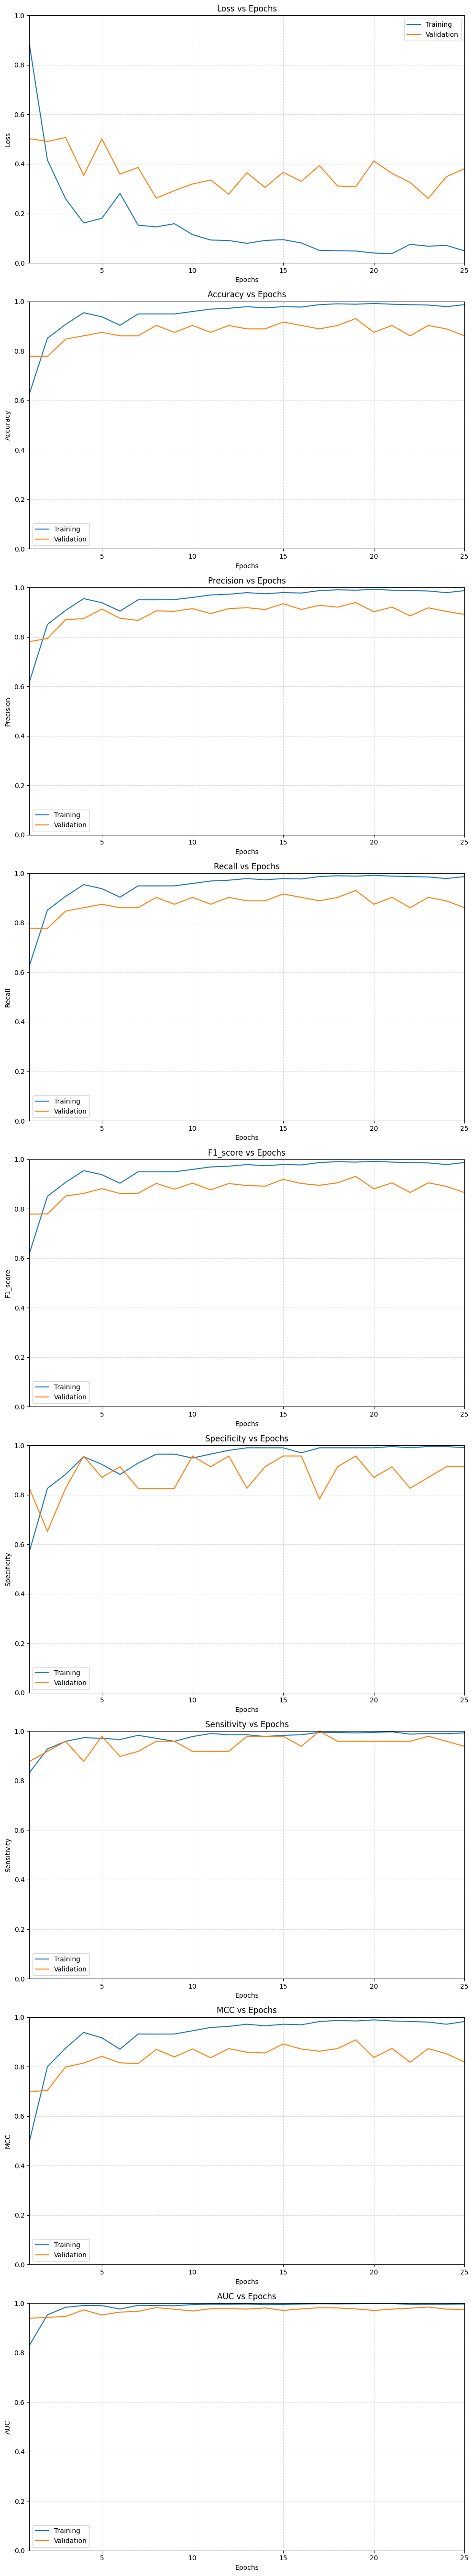

In [23]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(f"{metric_name.upper()} vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(f"{metric_name.capitalize()} vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        # Adjust xlim to avoid identical low and high limits.
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [24]:
# Testing loop
model.eval()
total_test_loss = 0.0
all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_test_loss += loss.item()

        all_test_predictions.extend(outputs.detach().cpu().numpy())
        all_test_targets.extend(targets.detach().cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)

average_test_loss = total_test_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_test_predictions), torch.tensor(all_test_targets), average_test_loss)
testing_metrics_line = "Test Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
print(testing_metrics_line)

Testing Model: 100%|██████████| 53/53 [00:02<00:00, 24.48it/s]

Test Metrics - loss: 0.3940, accuracy: 0.8667, precision: 0.8807, recall: 0.8667, f1_score: 0.8650, specificity: 0.7250, sensitivity: 0.9692, mcc: 0.8243, auc: 0.9663


In [ ]:
# Convert true labels and predictions to numpy
true_labels = np.array(all_test_targets)
predicted_labels = np.argmax(np.array(all_test_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

classes = CLASS_NAMES

# Classification report
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=classes,
    digits=4
)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(
    f"There were {num_errors} errors in {len(predicted_labels)} tests "
    f"for an accuracy of {accuracy*100:.2f}%"
)


                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.9355    0.7250    0.8169       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.7612    1.0000    0.8644        51
                                          normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.8039    0.9111    0.8542        90

                                        accuracy                         0.8667       315
                                       macro avg     0.8751    0.9044    0.8815       315
                                    weighted avg     0.8807    0.8667    0.8650       315

There were 42 errors in 315 tests for an accuracy of 86.67%
